In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Layer, Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# SelfAttention class definition
class SelfAttention(Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.query = Dense(self.channels)
        self.key = Dense(self.channels)
        self.value = Dense(self.channels)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        # Query, Key, Value transformations
        Q = self.query(inputs)
        K = self.key(inputs)
        V = self.value(inputs)

        # Attention scores
        attention_scores = tf.matmul(Q, K, transpose_b=True)
        attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.channels, tf.float32))
        attention_weights = self.softmax(attention_scores)

        # Compute the output
        output = tf.matmul(attention_weights, V)
        return output + inputs  # residual connection

    def compute_output_shape(self, input_shape):
        return input_shape
    
# 加載CIFAR-10數據集
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# 將標籤轉換為one-hot編碼格式
train_labels_onehot = to_categorical(train_labels, 10)
test_labels_onehot = to_categorical(test_labels, 10)

# 定義單純的CNN模型
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

# 定義結合Self-Attention的CNN模型
def create_cnn_attention_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        SelfAttention(64),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

# 訓練模型
def train_model(model):
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    model.fit(train_images, train_labels_onehot, epochs=10, batch_size=64, validation_data=(test_images, test_labels_onehot))
    return model

# 訓練兩種模型
cnn_model = train_model(create_cnn_model())
cnn_attention_model = train_model(create_cnn_attention_model())

Epoch 1/10
782/782 [==============================] - 38s 47ms/step - loss: 1.5136 - accuracy: 0.4587 - precision: 0.7011 - recall: 0.2153 - val_loss: 1.3549 - val_accuracy: 0.5163 - val_precision: 0.6731 - val_recall: 0.3444
Epoch 2/10
782/782 [==============================] - 70s 89ms/step - loss: 1.1754 - accuracy: 0.5899 - precision: 0.7459 - recall: 0.4105 - val_loss: 1.1059 - val_accuracy: 0.6164 - val_precision: 0.7562 - val_recall: 0.4604
Epoch 3/10
782/782 [==============================] - 73s 93ms/step - loss: 1.0338 - accuracy: 0.6422 - precision: 0.7747 - recall: 0.5010 - val_loss: 1.0638 - val_accuracy: 0.6317 - val_precision: 0.7572 - val_recall: 0.5009
Epoch 4/10
782/782 [==============================] - 63s 80ms/step - loss: 0.9487 - accuracy: 0.6695 - precision: 0.7882 - recall: 0.5500 - val_loss: 0.9960 - val_accuracy: 0.6612 - val_precision: 0.7778 - val_recall: 0.5412
Epoch 5/10
782/782 [==============================] - 53s 67ms/step - loss: 0.8734 - accuracy: 0

313/313 [==============================] - 2s 7ms/step


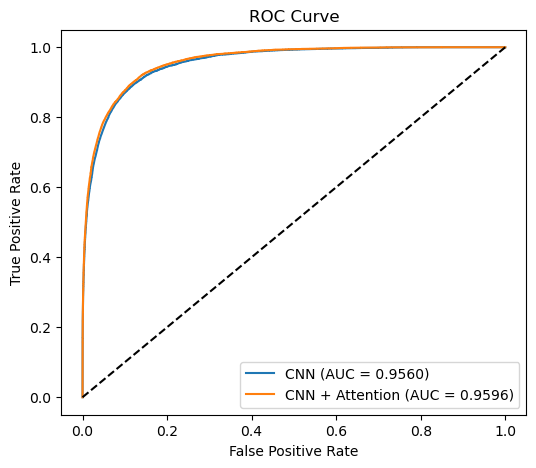

In [2]:
# 計算ROC曲線的各個點
y_pred_cnn = cnn_model.predict(test_images)
y_pred_cnn_attention = cnn_attention_model.predict(test_images)

fpr_cnn, tpr_cnn, _ = roc_curve(test_labels_onehot.ravel(), y_pred_cnn.ravel())
fpr_cnn_attention, tpr_cnn_attention, _ = roc_curve(test_labels_onehot.ravel(), y_pred_cnn_attention.ravel())

# 計算AUC值
auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_cnn_attention = auc(fpr_cnn_attention, tpr_cnn_attention)

# 繪製ROC曲線
plt.figure(figsize=(6, 5))
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {auc_cnn:.4f})')
plt.plot(fpr_cnn_attention, tpr_cnn_attention, label=f'CNN + Attention (AUC = {auc_cnn_attention:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
